# Colorization of Black and White Images

### Load Dataset

In [1]:
import numpy as np
from skimage.color import lab2rgb, rgb2lab, rgb2gray
from skimage.io import imsave
from IPython.display import display, Image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.datasets import cifar10

(X_train, _), (X_test, _) = cifar10.load_data()
print(X_train.shape)
print(X_test.shape)

/home/sourish/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(50000, 32, 32, 3)
(10000, 32, 32, 3)


### Image Preprocessing

In [2]:
X_train = 1.0/255 * X_train.astype('float32')
X_test = 1.0/255 * X_test.astype('float32')

batch_size = 32

from  scipy import ndimage
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

batch_size = 32
def generateImage(batch_size=32):
    for batch in datagen.flow(X_train, batch_size=batch_size):
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield (X_batch.reshape(X_batch.shape+(1,)), Y_batch)



### Build Model

In [3]:
from keras.models import Sequential
from keras.layers import Conv2D, InputLayer, UpSampling2D
from keras.layers import Activation, Dropout, Dense


model = Sequential()
model.add(InputLayer(input_shape=(None, None, 1)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.compile(optimizer='rmsprop', loss='mse')

### Train model

In [4]:
model.fit_generator(generateImage(), epochs=5, steps_per_epoch=500)
# Test images
X = rgb2lab(X_test)[:,:,:,0]
X = X.reshape(X.shape+(1,))
y_test = rgb2lab(X_test)[:,:,:,1:]
y_test = y_test / 128
print(model.evaluate(X, y_test, batch_size=32))

Epoch 1/5
500/500 [==============================] - 150s 300ms/step - loss: 0.0161
Epoch 2/5
500/500 [==============================] - 148s 296ms/step - loss: 0.0104
Epoch 3/5
500/500 [==============================] - 147s 294ms/step - loss: 0.0103
Epoch 4/5
500/500 [==============================] - 153s 306ms/step - loss: 0.0100
Epoch 5/5
10000/10000 [==============================] - 26s 3ms/step
0.009841199027001857


### Save Model

In [5]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")

### Test Model

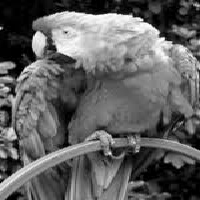

(1, 200, 200, 2)


/home/sourish/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


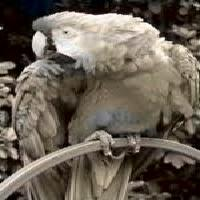

In [7]:
display(load_img('parrot.jpeg', target_size=(200, 200)))
image = img_to_array(load_img('parrot.jpeg', target_size=(200, 200)))
image = np.array(image, dtype=float) / 255

# Convert images from RGB to LAB
X = rgb2lab(image)[:,:,0]

X = X.reshape(1, X.shape[0], X.shape[1], 1)

output = model.predict(X)
output *= 128
print(output.shape)
# Output colorizations
cur = np.zeros((200, 200, 3))
cur[:,:,0] = X[0][:,:,0]
cur[:,:,1:] = output[0]
imsave("img_result.jpeg", lab2rgb(cur))
display(Image('img_result.jpeg'))
# imsave("img_gray_version.png", rgb2gray(lab2rgb(cur)))